# Notebook with Face Detection Attempts
© ~~Обучить~~ нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек.

In [1]:
import random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cpu


In [2]:
# Download picture with people
!gdown 1pivRzStoQgPlFBvjRwda6zvkjLHr_yYp

Downloading...
From: https://drive.google.com/uc?id=1pivRzStoQgPlFBvjRwda6zvkjLHr_yYp
To: /kaggle/working/IMG_20250103_175906_259.jpg
100%|████████████████████████████████████████| 174k/174k [00:00<00:00, 74.8MB/s]


In [3]:
# Package for face detection
!pip install --no-deps facenet-pytorch
from facenet_pytorch import MTCNN
detector = MTCNN()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.7 MB/s eta 0:00:00a 0:00:01


/usr/local/lib/python3.10/dist-packages/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
/usr/local

## Detect faces

In [4]:

img = read_image('/kaggle/working/IMG_20250103_175906_259.jpg')
np_img = torch.permute(img, (1, 2, 0)).numpy()

# Detect faces
boxes, probs, landmarks = detector.detect(np_img, landmarks=True)

detected = pd.DataFrame({'boxes': boxes.tolist(), 'probs': probs.tolist(), 'landmarks': landmarks.tolist()})
detected = detected[detected['probs'] > 0.95]
boxes, probs, landmarks = detected['boxes'], detected['probs'], detected['landmarks']

In [5]:
def render_tensor(img, device, boxes=None, probs=None, landmarks=None):
    # Display the image
    if str(device) == 'cuda':
        plt.imshow(torch.permute(img, (1, 2, 0)).cpu())
    else:
        plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.axis('off')
    
    # Iterate through provided overlays
    if boxes is not None:
        ax = plt.gca()
        clrs = ['b', 'g', 'r', 'c', 'm', 'y']
        
        for i, box in enumerate(boxes):
            color = random.choice(clrs)
            rect = Rectangle(
                (box[0], box[1]), # x, y
                box[2]-box[0], box[3]-box[1], # width, height
                linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
                
            if probs is not None:
                prob = probs[i]
                ax.text(
                    box[0], box[1], # x, y
                    f"{(100*prob):.0f}%", # text
                    fontsize=8, color=color, weight='bold',
                    bbox=dict(fill=False, linewidth=0))
        
            if landmarks is not None:
                landmark = landmarks[i]
                ax.scatter(
                    np.array(landmark)[:, 0], # xs
                    np.array(landmark)[:, 1], # ys
                    s=2, color=color)
    
    plt.show()
    return

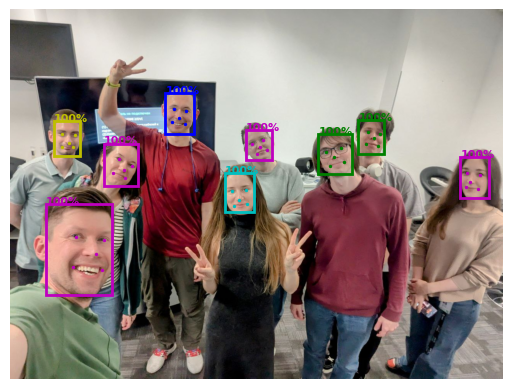

In [6]:
render_tensor(
    img, DEVICE,
    boxes=boxes,
    probs=probs,
    landmarks=landmarks
)

## Extract face(s)

In [21]:
def extract_face(img, box, landmark):
    box = list(map(int, box))

    new_landmark = []
    for dot in landmark:
        new_x = int(dot[0]-box[0])
        new_y = int(dot[1]-box[1])
        new_landmark.append([new_x, new_y])

    if isinstance(img, np.ndarray):
        face = img[box[1]:box[3], box[0]:box[2], :]
        face = torch.Tensor(face).type(torch.uint8)
    elif isinstance(img, torch.Tensor):
        face = img[:, box[1]:box[3], box[0]:box[2]]
        face = face.permute((1,2,0))
    else:
        raise Exception("Got nor torch.Tensor nor numpy.ndarray")

    new_landmark = torch.Tensor(new_landmark)
    new_landmark = new_landmark.repeat(1, 2)
    new_landmark = tv_tensors.BoundingBoxes(
        new_landmark, format='XYXY', canvas_size=face.shape[:2]
    )
    
    return {'image': face, 'landmarks': new_landmark}

image for extraction type: <class 'numpy.ndarray'>
Extracting the face...
Face shape: torch.Size([104, 89, 3])


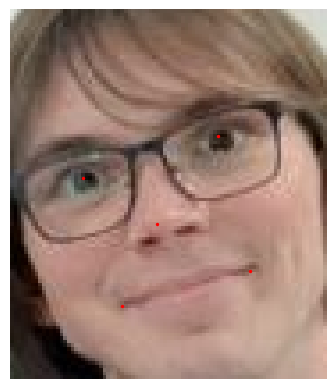

Landmarks:
BoundingBoxes([[20., 47., 20., 47.],
               [58., 35., 58., 35.],
               [41., 60., 41., 60.],
               [31., 83., 31., 83.],
               [67., 73., 67., 73.]], format=BoundingBoxFormat.XYXY, canvas_size=torch.Size([104, 89]))


In [22]:
# extract face from numpy ndarray
print(f"image for extraction type: {type(np_img)}")
print("Extracting the face...")
face = extract_face(np_img, boxes[2], landmarks[2])

print(f"Face shape: {face['image'].shape}")
plt.imshow(face['image'])

ax = plt.gca()
ax.scatter(face['landmarks'][:, 0], face['landmarks'][:, 1], s=2, color='r')
plt.axis('off')
plt.show()
print(f"Landmarks:\n{face['landmarks']}")

image for extraction type: <class 'torch.Tensor'>
Extracting the face...
Face shape: torch.Size([104, 89, 3])


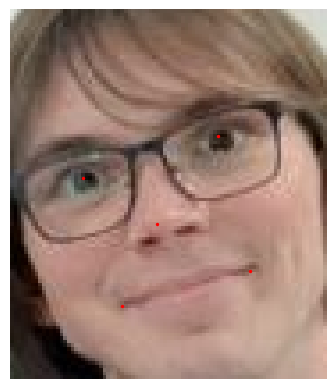

Landmarks:
BoundingBoxes([[20., 47., 20., 47.],
               [58., 35., 58., 35.],
               [41., 60., 41., 60.],
               [31., 83., 31., 83.],
               [67., 73., 67., 73.]], format=BoundingBoxFormat.XYXY, canvas_size=torch.Size([104, 89]))


In [23]:
# extract face from torch tensor (PREFERED)
print(f"image for extraction type: {type(img)}")
print("Extracting the face...")
face = extract_face(img, boxes[2], landmarks[2])

print(f"Face shape: {face['image'].shape}")
plt.imshow(face['image'])

ax = plt.gca()
ax.scatter(face['landmarks'][:, 0], face['landmarks'][:, 1], s=2, color='r')
plt.axis('off')
plt.show()
print(f"Landmarks:\n{face['landmarks']}")

## Align the face

### Check faces save their landmarks after transformations

In [24]:
transforms = v2.Compose([
    v2.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.1),
    v2.RandomAdjustSharpness(sharpness_factor=4, p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(-10, 10)),
    v2.RandomAffine(degrees=0, scale=(0.9, 1.1)),
])

In [32]:
transformed_faces = [(
    face['image'].permute(2,0,1), face['landmarks']
)]

for i in range(4):
    transformed_faces.append(
        transforms(face['image'].permute(2,0,1), face['landmarks'])
    )

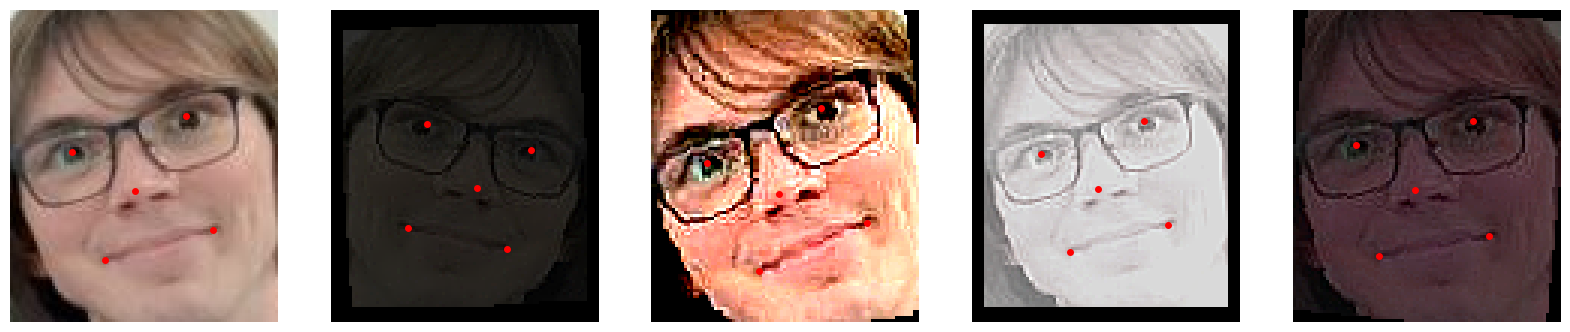

In [47]:
plt.figure(figsize=[20, 7])

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(transformed_faces[i][0].permute(1,2,0))

    ax = plt.gca()
    ax.scatter(transformed_faces[i][1][:, 0], transformed_faces[i][1][:, 1], s=16, color='r')
    plt.axis('off')